In [1]:
import os
import boto3
import pyart
import numpy as np
import matplotlib.pyplot as plt

from botocore import UNSIGNED
from botocore.client import Config
from datetime import datetime, timedelta

from functools import partial
from multiprocessing import Pool, cpu_count

import warnings
warnings.filterwarnings('ignore')


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
def s3_list_files(bucket_name, prefix):
    
    client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
    paginator = client.get_paginator("list_objects")

    page_iterator = paginator.paginate(Bucket=bucket_name, Prefix=prefix)
    keys = []
    for page in page_iterator:
        if "Contents" in page:
            for key in page["Contents"]:
                keyString = key["Key"]
                keys.append(keyString)

    return keys if keys else []

def s3_to_temp(object_name, bucket_name, tmp):
    
    client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
    
    file_dir = tmp + '/' + '/'.join(object_name.split('/')[:-1])
    os.makedirs(file_dir, exist_ok=True)

    f = object_name.split('/')[-1]
    client.download_file(bucket_name, object_name, file_dir + '/' + f)
    
    return file_dir + '/' + f

In [3]:
user = 'u1070830'

temp_dir = '/scratch/general/lustre/%s/radar/'%user
os.makedirs(temp_dir, exist_ok=True)

s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
bucket = 'noaa-nexrad-level2'

In [4]:
site = 'KMTX'
get_hour = datetime(2020, 5, 15, 12)

In [5]:
obj_list = [f for f in s3_list_files(bucket, 
                                     prefix='%04d/%02d/%02d/%s'%(
                                         get_hour.year, get_hour.month, get_hour.day, site),) 
            if (('.tar' not in f)&('MDM' not in f))]

get_these_hours = np.arange(9, 18+1, 1)

print(obj_list[0])

try:
    obj_list = [f for f in obj_list if int(f.split('_')[-1][:2]) in get_these_hours]
except:
    obj_list = [f for f in obj_list if int(f.split('_')[1][:2]) in get_these_hours]

2020/05/15/KMTX/KMTX20200515_000154_V06


In [6]:
s3_to_temp_mp = partial(s3_to_temp, bucket_name=bucket, tmp=temp_dir)

with Pool(cpu_count()-1) as p:
    filelist = p.map(s3_to_temp_mp, obj_list)
    p.close()
    p.join()
    
filelist = np.array(sorted(filelist))

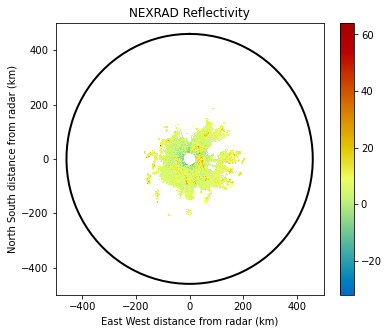

In [7]:
f = filelist[0]

radar = pyart.io.read_nexrad_archive(f)
display = pyart.graph.RadarDisplay(radar)
fig = plt.figure(figsize=(6, 5))

# plot super resolution reflectivity
ax = fig.add_subplot(111)
display.plot('reflectivity', 0, title='NEXRAD Reflectivity',
             vmin=-32, vmax=64, colorbar_label='', ax=ax)
display.plot_range_ring(radar.range['data'][-1]/1000., ax=ax)
display.set_limits(xlim=(-500, 500), ylim=(-500, 500), ax=ax)

plt.show()

In [8]:
for f in filelist:
    try:
        os.remove(f)
    except:
        print(f, 'does not exist')
    else:
        print(f, 'deleted')

/scratch/general/lustre/u1070830/radar//2020/05/15/KMTX/KMTX20200515_090157_V06 deleted
/scratch/general/lustre/u1070830/radar//2020/05/15/KMTX/KMTX20200515_090618_V06 deleted
/scratch/general/lustre/u1070830/radar//2020/05/15/KMTX/KMTX20200515_091039_V06 deleted
/scratch/general/lustre/u1070830/radar//2020/05/15/KMTX/KMTX20200515_091459_V06 deleted
/scratch/general/lustre/u1070830/radar//2020/05/15/KMTX/KMTX20200515_091919_V06 deleted
/scratch/general/lustre/u1070830/radar//2020/05/15/KMTX/KMTX20200515_092340_V06 deleted
/scratch/general/lustre/u1070830/radar//2020/05/15/KMTX/KMTX20200515_092801_V06 deleted
/scratch/general/lustre/u1070830/radar//2020/05/15/KMTX/KMTX20200515_093222_V06 deleted
/scratch/general/lustre/u1070830/radar//2020/05/15/KMTX/KMTX20200515_093643_V06 deleted
/scratch/general/lustre/u1070830/radar//2020/05/15/KMTX/KMTX20200515_094103_V06 deleted
/scratch/general/lustre/u1070830/radar//2020/05/15/KMTX/KMTX20200515_094524_V06 deleted
/scratch/general/lustre/u1070830